In [1]:
import pandas as pd
import numpy as np
import glob

import os
from pathlib import Path

import cv2 
from PIL import Image 
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator #imagedatagenerater는 이미지를 학습시킬 때 학습 데이터의 양이 적을 경우 학습데이터를 조금씩 변형 시켜서 학습데이터의 양을 늘리는 방식중 하나입니다.
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')# IPython 에서 제공하는 Rich output 에 대한 표현 방식입니다.

#난수 랜덤성 고정
np.random.seed(42)

%matplotlib inline

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
# 데이터 위치 설정합니다.
data_dir = Path('./Meta')
train_path = Path('./Train')
test_path = Path('./Test')

# 전처리: 이미지 별로 사이즈가 다르기 때문에 이미지의 폭과 높이를 같은 크기로 통일합니다.
IMG_HEGHT = 30
IMG_WIDTH = 30
channels = 3

# 현재 디렉토리 위치 변경합니다.
os.chdir("/Users/jsh/.kaggle/gtsrb-german-traffic-sign")
Path.cwd()

# 카테고리 수 확인합니다.
NUM_CATEGORIES = len(os.listdir(data_dir)) # lock이 있어서 45개로 나오지만 클래스는 43개 입니다 lock을 지워주면 됩니다.

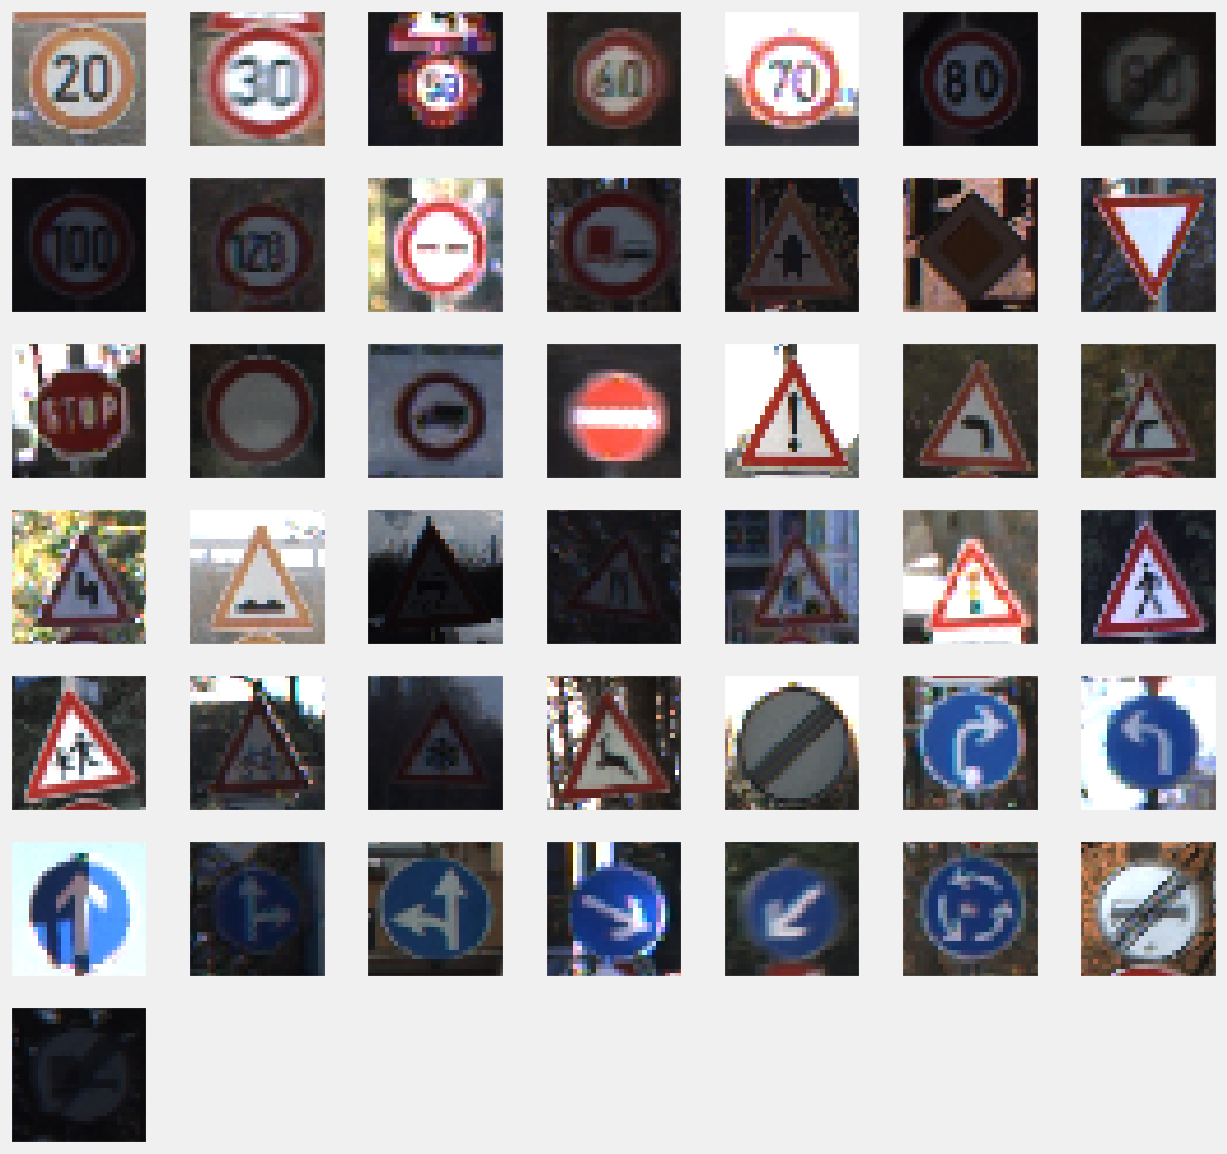

In [4]:
## 데이터 전처리

# 이미지 확인
plt.figure(figsize=(14, 14))
for i in range(NUM_CATEGORIES):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    sign = list(glob.glob(f'./Train/{i}/*'))[0]
    img = load_img(sign, target_size=(30, 30))
    plt.imshow(img)

plt.show()

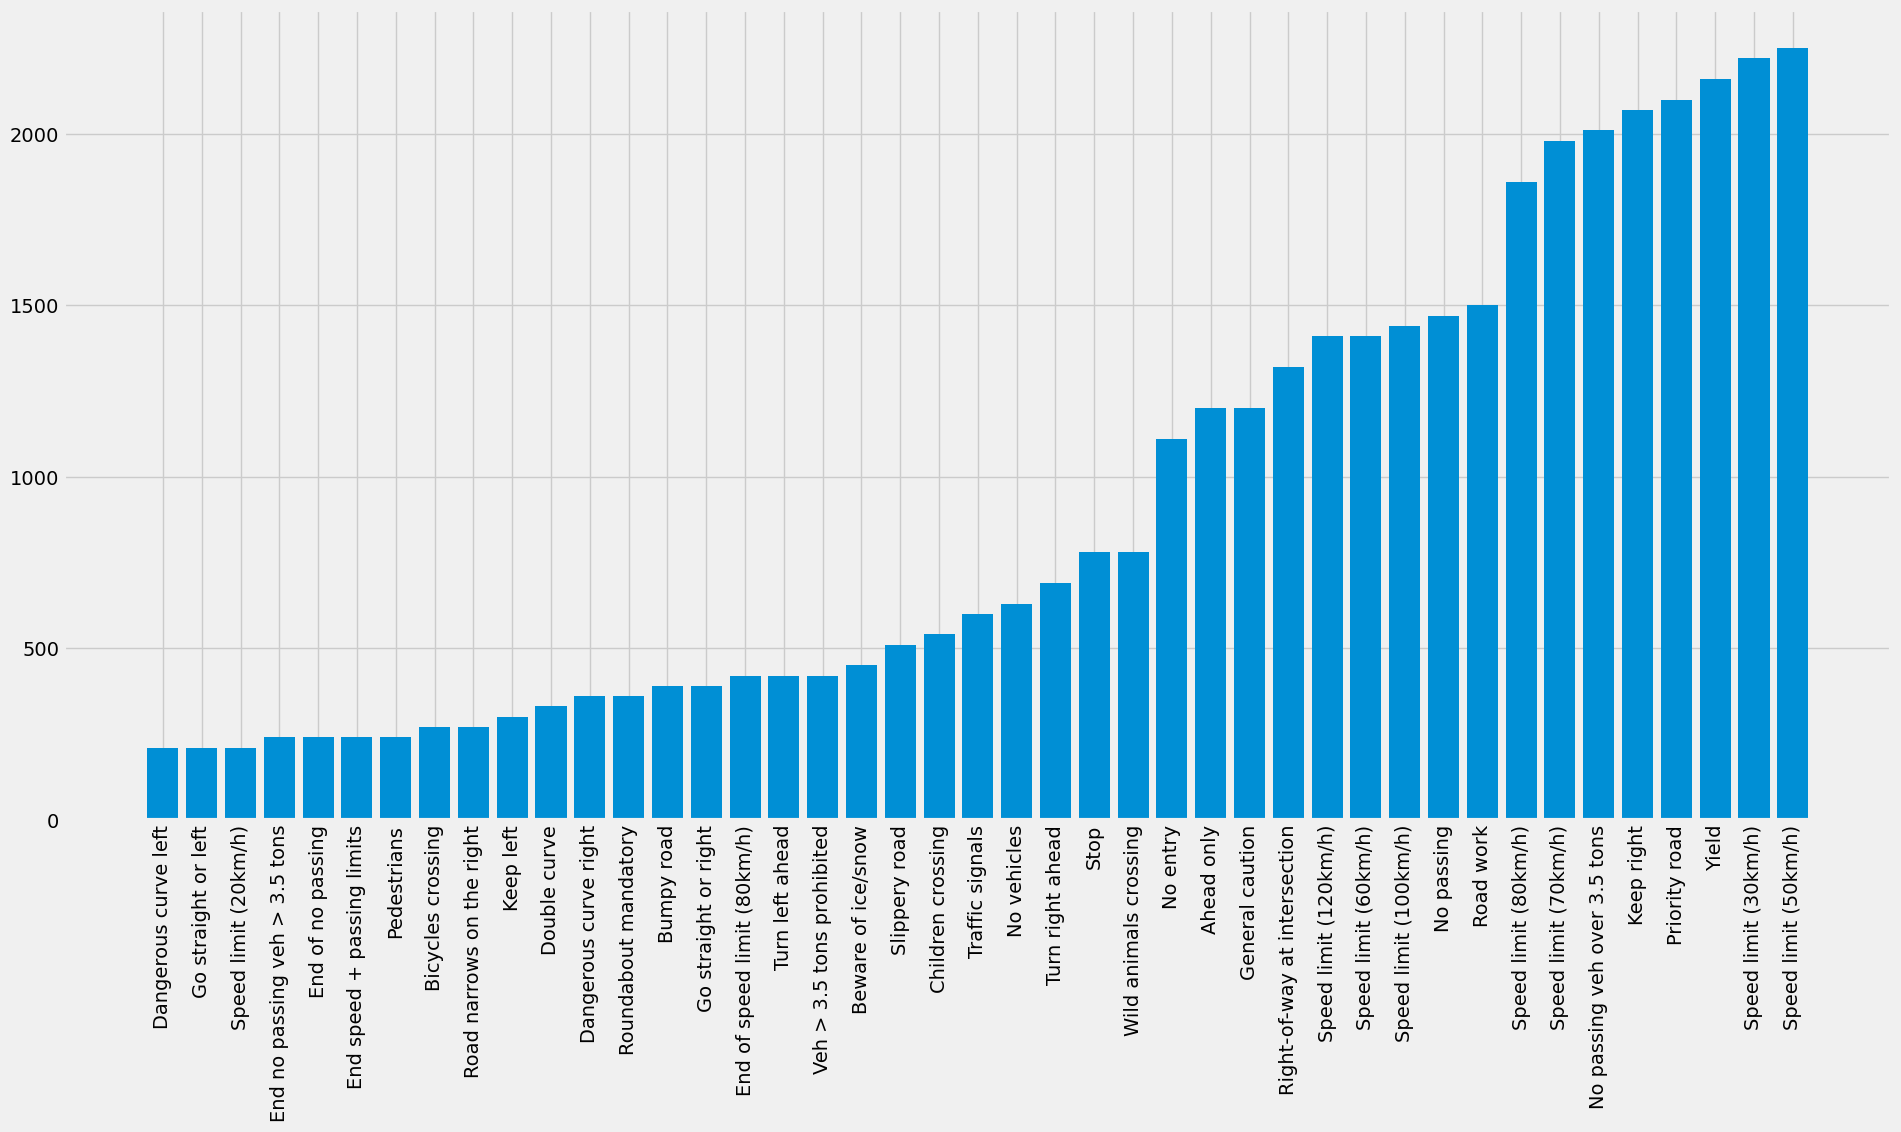

In [5]:
# Labeling
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

folders = os.listdir('./Train')

train_num = []
class_num = []

for folder in folders:
  train_files = os.listdir(str(train_path) + '/'+ folder)
  train_num.append(len(train_files))
  class_num.append(classes[int(folder)])

# 각각의 클래스의 이미지의 수에 기초해 데이터셋 분류하기
zipped_lists =  zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples =  zip(*sorted_pairs)
train_num, class_num = [ list(tuple) for tuple in tuples]

# 시각화
plt.figure(figsize = (21, 10))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [6]:
## data_loader
def load_data(data_dir):
    images = list()
    labels = list()
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=(30, 30))
            image = img_to_array(img) # 이미지를 넘파이 배열로 변환
            images.append(image) 
            labels.append(category)
    
    return images, labels
    
images, labels = load_data(train_path)

# labels에 원핫 인코딩 진행
labels = to_categorical(labels)

# 트레인, 테스트 셋 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.4)

In [7]:
## model
model = Sequential()

IMG_HEIGHT = 30
IMG_WIDTH = 30

# 첫번째 Convolutional Layer : 입력 데이터로부터 특징을 추출
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# 두번째 Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25)) # 인풋데이터의 25%를 무작위로 0으로 만듦

# 세번째 Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu')) # 특징을 추출하는 기능을 하는 필터, 비선형 값으로 바꿔주는 activation 함수->relu
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [9]:
## Test
# 모델 컴파일 하기
model.compile(
    loss='categorical_crossentropy', # 다중분류의 로스 함수
    optimizer='adam',
    metrics=['accuracy']
)

# 모델 핏하기
EPOCHS = 30
history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS, 
                    steps_per_epoch=60
                   )

Epoch 1/30


2023-05-06 19:28:54.721763: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


: 

: 

In [3]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

NameError: name 'model' is not defined